# Evolution of Einstein's equations

# Initial data , setting length of the domain and discretization


In [1]:
m = 2
A = 0.01#0.0492646484375#0.001#0.049375#5#0.0492645084166179#0.049264507293701174#0.049264508247375494#0.04925#0.0493#0.001#0.049375#0.07#0.05#0.1124921875#0.125
run = 1

1

In [2]:
global loggrid=true#true
global bisection=false
global meshrefinement=false;

In [3]:
using Quadmath, Printf

res=m;
N=2.0^m*100.0#2.0^m*1000.0/2.0#Nt=2.0^m*1000.0/2.0
Xf=1.0#Float128(1.0);

dx=Xf/N#Float128(Xf/N);
if loggrid==false
    dt=0.5*round(dx,digits=10)
else
    dt=0.1*round(dx,digits=10)
end
Nt=2.0^m*100.0#2.0^m*1000.0/2.0#Nt=2.0^m*1000.0/2.0
Tf=Nt*dt; #final time
#print(Tf)

In [4]:
print(N)

400.0

In [5]:
println("dx =", dx)
println("dt =", dt)
println("dx/dt =", dx/dt)

dx =0.0025
dt =0.00025
dx/dt =10.0


In [6]:
global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA" #~/data/ritapsantos/
#global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

# Grid

In [7]:
using Printf
include("./ScalarField.jl");

In [8]:
ori=0.0#Float128(0.0)#0.0;
initX1 = nothing
N=int(N)
initX1=range(ori, stop=Xf, step=dx);
#initX1=create_range(ori,Xf,dx,N)
initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)
#initX=create_range(ori-3.0*dx,Xf+3.0*dx,dx,N+6)

L=length(initX);
println("step size is  ", dx)
println("the time step is ", dt)

if loggrid==true
    global originalX=initX
    xtilde=gridfunc(initX1)
    initX1=xtilde
    initX=collect(initX)
    initX[4:L-3]=xtilde
end;

step size is  0.0025
the time step is 0.00025


# Initial data of m β Ψ and Ψ,x

In [9]:
using Dierckx
using Quadmath


####
#initm=Array{Float128}(undef, L)
#initbeta=Array{Float128}(undef, L)
#initpsi=Array{Float128}(undef, L)
#initderpsi=Array{Float128}(undef, L)
initm=zeros(L);
initbeta=zeros(L);
initpsi=zeros(L);
initderpsi=zeros(L);

state_array=[initm initbeta initpsi initderpsi initX];

#PSI
r0=0.7#0.01#0.7#0.01#0.7#0.7#0.7#0.01#0.7#0.3
sigma=0.3
initpsi[4:L-3] = init_gaussian(initX1,r0,sigma,A)

state_array[:,3] = initpsi
state_array = ghost(state_array)

#PSI,X FROM PSI
initderpsi[4:L-3] = init_gaussian_der(initX1,r0,sigma,A)
state_array[:,4] = initderpsi
state_array=ghost(state_array)

####

derpsi_func = Spline1D(initX[4:L-3], state_array[4:L-3,4],  k=4);

In [10]:
y0=[0 0 0]

state_array[4:L-3,1:3] = n_rk4wrapper(RHS,y0,initX[4:L-3],0,derpsi_func,state_array[:,:]);

state_array = ghost(state_array);

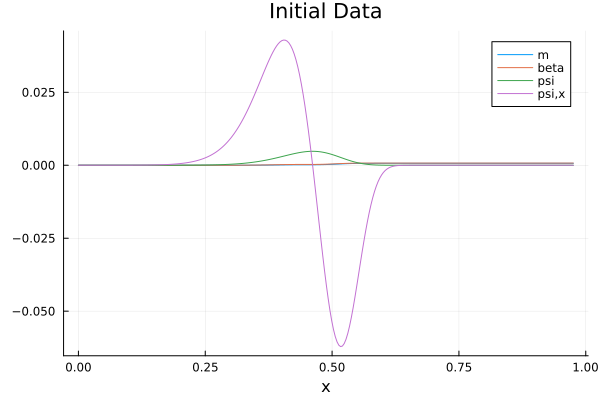

In [11]:
using Plots #showing initial data and the initial status of the horizon finder
plot(initX[4:L-3], state_array[4:L-3,1:4], xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [12]:
using CSV, Tables, Printf
#CSV.write(dir*"/time_step0.csv", Tables.table(transpose(Matrix(state_array))), writeheader=false)
#CSV.write(dir*"/res$res/time_step0.csv", Tables.table(state_array), writeheader=false)

global files=["m", "beta", "psi", "derpsi"]

print_muninn(files, 0, state_array[:,1:5],res,"w")

In [13]:
time=0.0
criticality=0.0
explode=0.0
evol_stats = [criticality A sigma r0 time explode run]
monitor_ratio = zeros(L)
CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=true, header=["criticality", "A", "sigma", "r0", "time", "explode", "run"])

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv"

In [14]:
ginit=speed(initX,state_array[:,1],state_array[:,2])
println(update_dt(initX,state_array[:,1],state_array[:,2],dx,ginit)/dt)

0.04996591249745638


In [15]:
using Base.Threads
Threads.nthreads()

4

 ## Time evolution

In [16]:
#global dt = 5e-5/2/2/2 #RES3
if m==1
    global dt=5e-5/2/5
elseif m==2
    global dt=5e-5/2/2/5
else
    global dt=5e-5/2/2/2/5
end

2.5e-6

fixed grid

In [ ]:
finaltime=2.0#1.3#1.6#2#1.3#0.08*2#0.005*10*5#1#0.9#0.8#0.04*5*4#length(T)-1
evol_stats, T_interp = timeevolution(state_array,finaltime,run);#timeevolution(state_array,finaltime,dir*"/res$res",run,auxstate_array);
#CSV.write(dir*"/timearray$res.csv", Tables.table(T_interp), writeheader=false);



iteration 500 dt is 2.5e-6, t=0.0012499999999999911 speed is 0.4999875089119545, dx/dt=999.9999999999999


iteration 1000 dt is 2.5e-6, t=0.00249999999999994 speed is 0.4999875089119545, dx/dt=999.9999999999999


iteration 1500 dt is 2.5e-6, t=0.0037499999999998893 speed is 0.4999875089119545, dx/dt=999.9999999999999


iteration 2000 dt is 2.5e-6, t=0.004999999999999839 speed is 0.4999875089119545, dx/dt=999.9999999999999


iteration 2500 dt is 2.5e-6, t=0.006249999999999788 speed is 0.4999875089119545, dx/dt=999.9999999999999


iteration 3000 dt is 2.5e-6, t=0.007499999999999737 speed is 0.4999875089119545, dx/dt=999.9999999999999


iteration 3500 dt is 2.5e-6, t=0.008750000000000011 speed is 0.4999875089119545, dx/dt=999.9999999999999


iteration 4000 dt is 2.5e-6, t=0.010000000000000394 speed is 0.4999875089119545, dx/dt=999.9999999999999


iteration 4500 dt is 2.5e-6, t=0.011250000000000777 speed is 0.4999875089119545, dx/dt=999.9999999999999


iteration 5000 dt is 2.5e-6, t=0.01



iteration 39000 dt is 2.5e-6, t=0.09750000000006231 speed is 0.4999875089119545, dx/dt=999.9999999999999


iteration 39500 dt is 2.5e-6, t=0.09875000000006356 speed is 0.4999875089119545, dx/dt=999.9999999999999


iteration 40000 dt is 2.5e-6, t=0.10000000000006481 speed is 0.4999875089119545, dx/dt=999.9999999999999


iteration 40500 dt is 2.5e-6, t=0.10125000000006606 speed is 0.4999875089119545, dx/dt=999.9999999999999


iteration 41000 dt is 2.5e-6, t=0.10250000000006732 speed is 0.4999875089119545, dx/dt=999.9999999999999


iteration 41500 dt is 2.5e-6, t=0.10375000000006857 speed is 0.4999875089119545, dx/dt=999.9999999999999


iteration 42000 dt is 2.5e-6, t=0.10500000000006982 speed is 0.4999875089119545, dx/dt=999.9999999999999


iteration 42500 dt is 2.5e-6, t=0.10625000000007107 speed is 0.4999875089119545, dx/dt=999.9999999999999


iteration 43000 dt is 2.5e-6, t=0.10750000000007232 speed is 0.4999875089119545, dx/dt=999.9999999999999


iteration 43500 dt is 2.5e-6, t=0.1



iteration 77500 dt is 2.5e-6, t=0.19374999999977693 speed is 0.49998750891195465, dx/dt=999.9999999999999


iteration 78000 dt is 2.5e-6, t=0.19499999999977125 speed is 0.49998750891195465, dx/dt=999.9999999999999


iteration 78500 dt is 2.5e-6, t=0.19624999999976556 speed is 0.49998750891195465, dx/dt=999.9999999999999


iteration 79000 dt is 2.5e-6, t=0.19749999999975987 speed is 0.4999875089119547, dx/dt=999.9999999999999


iteration 79500 dt is 2.5e-6, t=0.19874999999975418 speed is 0.49998750891195465, dx/dt=999.9999999999999


iteration 80000 dt is 2.5e-6, t=0.1999999999997485 speed is 0.49998750891195465, dx/dt=999.9999999999999


iteration 80500 dt is 2.5e-6, t=0.2012499999997428 speed is 0.49998750891195465, dx/dt=999.9999999999999


iteration 81000 dt is 2.5e-6, t=0.2024999999997371 speed is 0.49998750891195465, dx/dt=999.9999999999999


iteration 81500 dt is 2.5e-6, t=0.20374999999973142 speed is 0.49998750891195465, dx/dt=999.9999999999999


iteration 82000 dt is 2.5e-6, 



iteration 116000 dt is 2.5e-6, t=0.289999999999783 speed is 0.49998750891195787, dx/dt=999.9999999999999


iteration 116500 dt is 2.5e-6, t=0.2912499999997912 speed is 0.49998750891195803, dx/dt=999.9999999999999


iteration 117000 dt is 2.5e-6, t=0.29249999999979936 speed is 0.49998750891195815, dx/dt=999.9999999999999


iteration 117500 dt is 2.5e-6, t=0.29374999999980755 speed is 0.4999875089119583, dx/dt=999.9999999999999


iteration 118000 dt is 2.5e-6, t=0.29499999999981574 speed is 0.49998750891195853, dx/dt=999.9999999999999


iteration 118500 dt is 2.5e-6, t=0.29624999999982393 speed is 0.4999875089119587, dx/dt=999.9999999999999


iteration 119000 dt is 2.5e-6, t=0.2974999999998321 speed is 0.4999875089119588, dx/dt=999.9999999999999


iteration 119500 dt is 2.5e-6, t=0.2987499999998403 speed is 0.49998750891195903, dx/dt=999.9999999999999


iteration 120000 dt is 2.5e-6, t=0.2999999999998485 speed is 0.49998750891195914, dx/dt=999.9999999999999


iteration 120500 dt is 2.5



iteration 154500 dt is 2.5e-6, t=0.38625000000041354 speed is 0.4999875089120264, dx/dt=999.9999999999999


iteration 155000 dt is 2.5e-6, t=0.38750000000042173 speed is 0.4999875089120292, dx/dt=999.9999999999999


iteration 155500 dt is 2.5e-6, t=0.3887500000004299 speed is 0.49998750891203214, dx/dt=999.9999999999999


iteration 156000 dt is 2.5e-6, t=0.3900000000004381 speed is 0.499987508912035, dx/dt=999.9999999999999


iteration 156500 dt is 2.5e-6, t=0.3912500000004463 speed is 0.4999875089120382, dx/dt=999.9999999999999


iteration 157000 dt is 2.5e-6, t=0.3925000000004545 speed is 0.4999875089120413, dx/dt=999.9999999999999


iteration 157500 dt is 2.5e-6, t=0.3937500000004627 speed is 0.4999875089120445, dx/dt=999.9999999999999


iteration 158000 dt is 2.5e-6, t=0.39500000000047086 speed is 0.4999875089120479, dx/dt=999.9999999999999


iteration 158500 dt is 2.5e-6, t=0.39625000000047905 speed is 0.49998750891205146, dx/dt=999.9999999999999


iteration 159000 dt is 2.5e-6,



iteration 193000 dt is 2.5e-6, t=0.4825000000010441 speed is 0.49998750891303045, dx/dt=999.9999999999999


iteration 193500 dt is 2.5e-6, t=0.4837500000010523 speed is 0.4999875089130661, dx/dt=999.9999999999999


iteration 194000 dt is 2.5e-6, t=0.48500000000106047 speed is 0.49998750891310273, dx/dt=999.9999999999999


iteration 194500 dt is 2.5e-6, t=0.48625000000106866 speed is 0.4999875089131406, dx/dt=999.9999999999999


iteration 195000 dt is 2.5e-6, t=0.48750000000107685 speed is 0.4999875089131796, dx/dt=999.9999999999999


iteration 195500 dt is 2.5e-6, t=0.48875000000108504 speed is 0.49998750891321975, dx/dt=999.9999999999999


iteration 196000 dt is 2.5e-6, t=0.4900000000010932 speed is 0.49998750891326127, dx/dt=999.9999999999999


iteration 196500 dt is 2.5e-6, t=0.4912500000011014 speed is 0.49998750891330385, dx/dt=999.9999999999999


iteration 197000 dt is 2.5e-6, t=0.4925000000011096 speed is 0.4999875089133477, dx/dt=999.9999999999999


iteration 197500 dt is 2.5



iteration 231500 dt is 2.5e-6, t=0.5787500000016746 speed is 0.4999875089223143, dx/dt=999.9999999999999


iteration 232000 dt is 2.5e-6, t=0.5800000000016828 speed is 0.49998750892258337, dx/dt=999.9999999999999


iteration 232500 dt is 2.5e-6, t=0.581250000001691 speed is 0.49998750892285815, dx/dt=999.9999999999999


iteration 233000 dt is 2.5e-6, t=0.5825000000016992 speed is 0.4999875089231387, dx/dt=999.9999999999999


iteration 233500 dt is 2.5e-6, t=0.5837500000017074 speed is 0.49998750892342525, dx/dt=999.9999999999999


iteration 234000 dt is 2.5e-6, t=0.5850000000017156 speed is 0.49998750892371757, dx/dt=999.9999999999999


iteration 234500 dt is 2.5e-6, t=0.5862500000017238 speed is 0.4999875089240161, dx/dt=999.9999999999999


iteration 235000 dt is 2.5e-6, t=0.587500000001732 speed is 0.49998750892432053, dx/dt=999.9999999999999


iteration 235500 dt is 2.5e-6, t=0.5887500000017402 speed is 0.49998750892463134, dx/dt=999.9999999999999


iteration 236000 dt is 2.5e-6, 



iteration 270000 dt is 2.5e-6, t=0.6750000000023052 speed is 0.4999875089606536, dx/dt=999.9999999999999


iteration 270500 dt is 2.5e-6, t=0.6762500000023134 speed is 0.49998750896127553, dx/dt=999.9999999999999


iteration 271000 dt is 2.5e-6, t=0.6775000000023216 speed is 0.49998750896189276, dx/dt=999.9999999999999


iteration 271500 dt is 2.5e-6, t=0.6787500000023298 speed is 0.49998750896250455, dx/dt=999.9999999999999


iteration 272000 dt is 2.5e-6, t=0.680000000002338 speed is 0.4999875089631105, dx/dt=999.9999999999999


iteration 272500 dt is 2.5e-6, t=0.6812500000023461 speed is 0.4999875089637098, dx/dt=999.9999999999999


iteration 273000 dt is 2.5e-6, t=0.6825000000023543 speed is 0.499987508964302, dx/dt=999.9999999999999


iteration 273500 dt is 2.5e-6, t=0.6837500000023625 speed is 0.4999875089648864, dx/dt=999.9999999999999


iteration 274000 dt is 2.5e-6, t=0.6850000000023707 speed is 0.49998750896546246, dx/dt=999.9999999999999


iteration 274500 dt is 2.5e-6, t=



iteration 308500 dt is 2.5e-6, t=0.7712500000029358 speed is 0.4999875089470963, dx/dt=999.9999999999999


iteration 309000 dt is 2.5e-6, t=0.7725000000029439 speed is 0.49998750894574207, dx/dt=999.9999999999999


iteration 309500 dt is 2.5e-6, t=0.7737500000029521 speed is 0.49998750894437194, dx/dt=999.9999999999999


iteration 310000 dt is 2.5e-6, t=0.7750000000029603 speed is 0.49998750894298827, dx/dt=999.9999999999999


iteration 310500 dt is 2.5e-6, t=0.7762500000029685 speed is 0.49998750894159344, dx/dt=999.9999999999999


iteration 311000 dt is 2.5e-6, t=0.7775000000029767 speed is 0.49998750894019006, dx/dt=999.9999999999999


iteration 311500 dt is 2.5e-6, t=0.7787500000029849 speed is 0.4999875089387805, dx/dt=999.9999999999999


iteration 312000 dt is 2.5e-6, t=0.7800000000029931 speed is 0.49998750893736804, dx/dt=999.9999999999999


iteration 312500 dt is 2.5e-6, t=0.7812500000030013 speed is 0.49998750893595545, dx/dt=999.9999999999999


iteration 313000 dt is 2.5e-



iteration 347000 dt is 2.5e-6, t=0.8675000000035663 speed is 0.4999875091175504, dx/dt=999.9999999999999


iteration 347500 dt is 2.5e-6, t=0.8687500000035745 speed is 0.4999875091284354, dx/dt=999.9999999999999


iteration 348000 dt is 2.5e-6, t=0.8700000000035827 speed is 0.4999875091396119, dx/dt=999.9999999999999


iteration 348500 dt is 2.5e-6, t=0.8712500000035909 speed is 0.4999875091510754, dx/dt=999.9999999999999


iteration 349000 dt is 2.5e-6, t=0.8725000000035991 speed is 0.49998750916282125, dx/dt=999.9999999999999


iteration 349500 dt is 2.5e-6, t=0.8737500000036073 speed is 0.49998750917484414, dx/dt=999.9999999999999


iteration 350000 dt is 2.5e-6, t=0.8750000000036154 speed is 0.4999875091871382, dx/dt=999.9999999999999


iteration 350500 dt is 2.5e-6, t=0.8762500000036236 speed is 0.4999875091996968, dx/dt=999.9999999999999


iteration 351000 dt is 2.5e-6, t=0.8775000000036318 speed is 0.4999875092125128, dx/dt=999.9999999999999


iteration 351500 dt is 2.5e-6, t=



iteration 385500 dt is 2.5e-6, t=0.9637500000041969 speed is 0.49998750979155465, dx/dt=999.9999999999999


iteration 386000 dt is 2.5e-6, t=0.965000000004205 speed is 0.4999875097804494, dx/dt=999.9999999999999


iteration 386500 dt is 2.5e-6, t=0.9662500000042132 speed is 0.49998750976858425, dx/dt=999.9999999999999


iteration 387000 dt is 2.5e-6, t=0.9675000000042214 speed is 0.4999875097559741, dx/dt=999.9999999999999


iteration 387500 dt is 2.5e-6, t=0.9687500000042296 speed is 0.49998750974263584, dx/dt=999.9999999999999


iteration 388000 dt is 2.5e-6, t=0.9700000000042378 speed is 0.4999875097285879, dx/dt=999.9999999999999


iteration 388500 dt is 2.5e-6, t=0.971250000004246 speed is 0.4999875097138507, dx/dt=999.9999999999999


iteration 389000 dt is 2.5e-6, t=0.9725000000042542 speed is 0.499987509698447, dx/dt=999.9999999999999


iteration 389500 dt is 2.5e-6, t=0.9737500000042624 speed is 0.49998750968240097, dx/dt=999.9999999999999


iteration 390000 dt is 2.5e-6, t=0



iteration 424000 dt is 2.5e-6, t=1.0600000000021628 speed is 0.4999875090679404, dx/dt=999.9999999999999


iteration 424500 dt is 2.5e-6, t=1.0612500000021154 speed is 0.49998750908158357, dx/dt=999.9999999999999


iteration 425000 dt is 2.5e-6, t=1.0625000000020681 speed is 0.4999875090954698, dx/dt=999.9999999999999


iteration 425500 dt is 2.5e-6, t=1.0637500000020208 speed is 0.499987509109551, dx/dt=999.9999999999999


iteration 426000 dt is 2.5e-6, t=1.0650000000019735 speed is 0.4999875091237792, dx/dt=999.9999999999999


iteration 426500 dt is 2.5e-6, t=1.0662500000019262 speed is 0.4999875091381064, dx/dt=999.9999999999999


iteration 427000 dt is 2.5e-6, t=1.0675000000018788 speed is 0.4999875091524852, dx/dt=999.9999999999999


iteration 427500 dt is 2.5e-6, t=1.0687500000018315 speed is 0.499987509166868, dx/dt=999.9999999999999


iteration 428000 dt is 2.5e-6, t=1.0700000000017842 speed is 0.49998750918120843, dx/dt=999.9999999999999


iteration 428500 dt is 2.5e-6, t=1.



iteration 462500 dt is 2.5e-6, t=1.156249999998519 speed is 0.49998750910077927, dx/dt=999.9999999999999


iteration 463000 dt is 2.5e-6, t=1.1574999999984716 speed is 0.49998750909199324, dx/dt=999.9999999999999


iteration 463500 dt is 2.5e-6, t=1.1587499999984243 speed is 0.49998750908342365, dx/dt=999.9999999999999


iteration 464000 dt is 2.5e-6, t=1.159999999998377 speed is 0.49998750907507855, dx/dt=999.9999999999999


iteration 464500 dt is 2.5e-6, t=1.1612499999983297 speed is 0.49998750906696493, dx/dt=999.9999999999999


iteration 465000 dt is 2.5e-6, t=1.1624999999982824 speed is 0.4999875090590886, dx/dt=999.9999999999999


iteration 465500 dt is 2.5e-6, t=1.163749999998235 speed is 0.4999875090514543, dx/dt=999.9999999999999


iteration 466000 dt is 2.5e-6, t=1.1649999999981877 speed is 0.49998750904406575, dx/dt=999.9999999999999


iteration 466500 dt is 2.5e-6, t=1.1662499999981404 speed is 0.49998750903692607, dx/dt=999.9999999999999


iteration 467000 dt is 2.5e-6, 



iteration 501000 dt is 2.5e-6, t=1.2524999999948752 speed is 0.49998750891206184, dx/dt=999.9999999999999


iteration 501500 dt is 2.5e-6, t=1.2537499999948278 speed is 0.4999875089120456, dx/dt=999.9999999999999


iteration 502000 dt is 2.5e-6, t=1.2549999999947805 speed is 0.49998750891203153, dx/dt=999.9999999999999


iteration 502500 dt is 2.5e-6, t=1.2562499999947332 speed is 0.4999875089120194, dx/dt=999.9999999999999


iteration 503000 dt is 2.5e-6, t=1.2574999999946859 speed is 0.499987508912009, dx/dt=999.9999999999999


iteration 503500 dt is 2.5e-6, t=1.2587499999946385 speed is 0.4999875089120001, dx/dt=999.9999999999999


iteration 504000 dt is 2.5e-6, t=1.2599999999945912 speed is 0.4999875089119926, dx/dt=999.9999999999999


iteration 504500 dt is 2.5e-6, t=1.261249999994544 speed is 0.4999875089119862, dx/dt=999.9999999999999


iteration 505000 dt is 2.5e-6, t=1.2624999999944966 speed is 0.4999875089119807, dx/dt=999.9999999999999


iteration 505500 dt is 2.5e-6, t=1.

 ## Movie of the evolution

In [19]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 0:100:3800#870
    
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/time_step$n.csv",header=false, delim=","))
    
    #functions3=DataFrame(CSV.File("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/bisectionsearch/run1"*"/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
        plot5=functions3.Column5[4:L-3];
    temp=round(n*dt,digits=2)
    plot!(initX1, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"], title="$temp", ylim=[-0.01, 0.01],xlim=[0, 1])#, xlim=[0, 0.1])# |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 10)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/time_step0.csv" is not a valid file or doesn't exist

In [ ]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 10:10:1000#length(T)-1
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/monitor_ratio$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
    
    plot!(initX1, [plot1], labels=["monitor ratio"], ylim=[0, 1])# |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 5)

# New test

In [ ]:
include("./ScalarField.jl");

function ff(x)

    return x^2

end
function gridd(x)

    #return(1/2+1/2*cos(pi*(1-0.9*x)))
    return(1/2 .+ 1/2 .* cos.(pi .* (1 .- x)))

end;

In [ ]:
res=1

dx=0.1

x=range(-3*dx,1+3*dx,step=dx)

y=ff.(x);

In [ ]:
L=length(x)
aux=zeros(L)


for i in 4:L-3

    aux[i]=Dertest(y,i,x)

end

println(aux[4:L-3]);
xnew=x
xnew[4:L-3]=gridd(x)[4:L-3]

#ynew=ff.(xnew);
ynew=[ff.(xnew) zeros(L)]

In [ ]:
gridd(x)[4:L-3]

In [ ]:
spl=Spline1D(xnew[4:L-3],ynew[4:L-3],k=4)
spl=[spl spl]
auxnew=zeros(L);
k=1

for i in 4:L-3
    auxnew[i]=unevenDer(ynew,i,k,xnew,spl)
end

println(" ")
println(auxnew[4:L-3])
println(" ")
println(2 .* xnew[4:L-3])

In [ ]:

#plot(x,y)

scatter(xnew[4:L-3],auxnew[4:L-3])#,xlim=[0,0.2])

#plot(x[4:L-3],aux[4:L-3])

In [ ]:
auxnew[L-3]